Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [ ]:
#load the images using keras preprocessing
train = keras.preprocessing.image_dataset_from_directory(data_dir_train)
test = keras.preprocessing.image_dataset_from_directory(data_dir_test)

Found 2239 files belonging to 9 classes.
Found 118 files belonging to 9 classes.



### Creating a dataset

Defining parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Train and validation split with 80% of the images for training, and 20% for validation. Using seed=123 and resizing the images.

In [ ]:
train_ds,val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels ='inferred', color_mode ='rgb',
                                                            batch_size = batch_size, image_size = (img_height, img_width),
                                                            seed=123, validation_split = 0.2, subset = 'both')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Images of one instance of all the nine classes present in the dataset

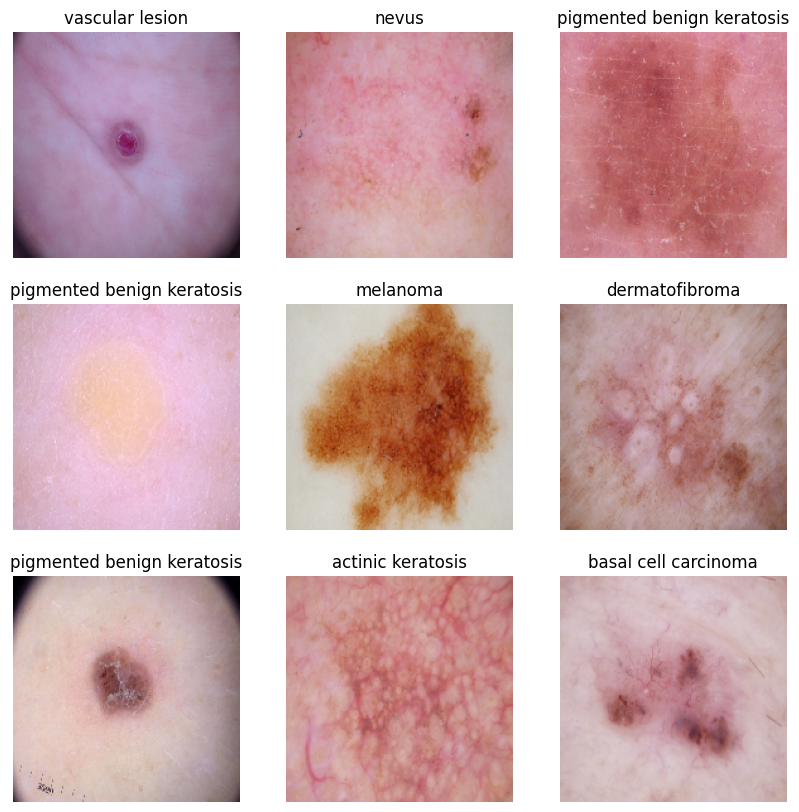

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
#model 1
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling((1./255), input_shape=(img_height, img_width, 3)),  # Changed from tf.keras.layers.experimental.preprocessing.Rescaling
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
#choosing an appropirate optimiser and loss function
model.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 771s 4s/step - accuracy: 0.1858 - loss: 2.2249 - val_accuracy: 0.3512 - val_loss: 1.8079
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.3769 - loss: 1.7598 - val_accuracy: 0.4676 - val_loss: 1.5509
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4408 - loss: 1.5512 - val_accuracy: 0.5391 - val_loss: 1.4585
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5127 - loss: 1.3907 - val_accuracy: 0.5257 - val_loss: 1.4319
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5358 - loss: 1.3146 - val_accuracy: 0.4810 - val_loss: 1.5444
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5568 - loss: 1.2288 - val_accuracy: 0.5391 - val_loss: 1.3843
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5954 - loss: 1.1439 - val_accuracy: 0.5414 - val_loss: 1.3547
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6044 - loss: 1.0882 - val_accuracy: 0.5302 - 

### Visualizing training results

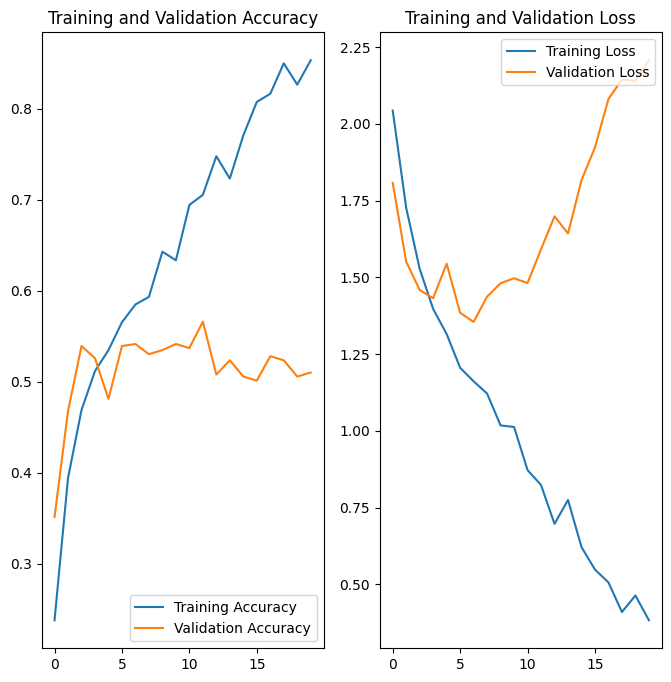

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Key Observations:

Accuracy: The training accuracy steadily increases, reaching a high value, while the validation accuracy also increases but plateaus at a lower value. This suggests that the model is overfitting.

Loss: The training loss decreases significantly, indicating that the model is learning the training data well. However, the validation loss also decreases initially but then starts to increase again. This further supports the overfitting hypothesis.
Overall, the model appears to be overfitting the training data. This means it is learning the training data too well and is not able to generalize well to new, unseen data.

Data Augmentation

In [ ]:
#Data Augmentation: Increasing the size and diversity of the training data can help the model generalize better.

rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)])

# Updated data_augmentation to use tf.keras.layers.preprocessing directly:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomTranslation(0.2, 0.2)
])


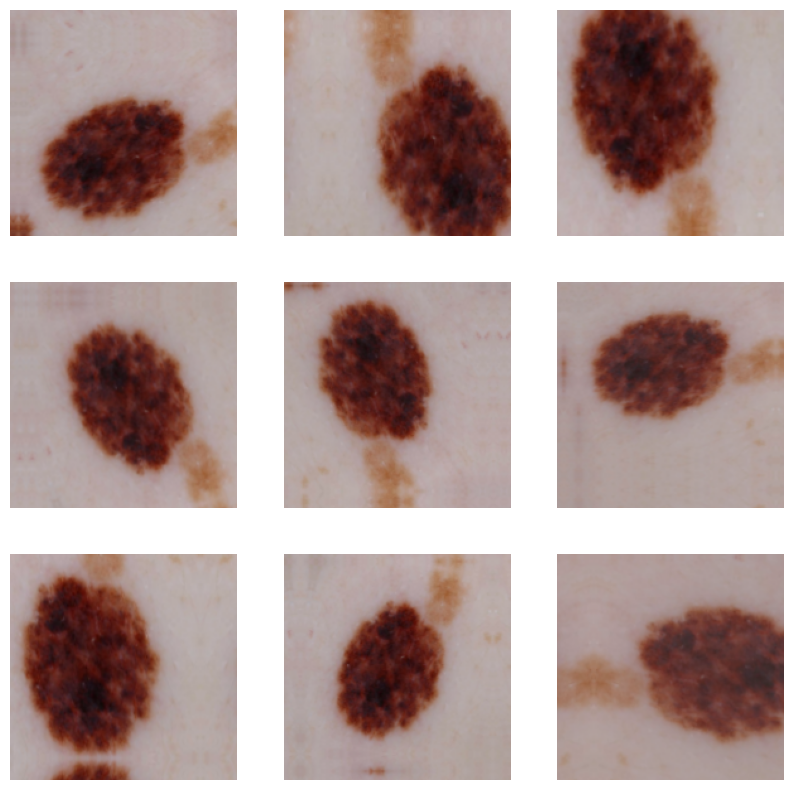

In [ ]:
# isualizing augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Creating the model, compile and train the model


In [ ]:
#using the dropout layers to overcome the overfitting


## Model 2 Creation

#Dropout layer: randomly sets input units to 0 with a frequency of rate at each step during training time,
#which helps prevent overfitting.Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

model2 = Sequential([
    data_augmentation,  # Augmentation layer
    rescale,            # Rescaling layer

    # First Convolutional Block
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout with 25%

    # Second Convolutional Block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout with 25%

    # Third Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Flatten(),  # Flatten the tensors

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.50),  # Dropout with 50%

    # Output Layer
    layers.Dense(len(class_names), activation='softmax')  # Softmax for probabilities
])

### Compiling the model

In [ ]:

model2.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## training the model for 20 epochs
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.1606 - loss: 3.1909 - val_accuracy: 0.1924 - val_loss: 2.0892
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.1921 - loss: 2.0640 - val_accuracy: 0.2081 - val_loss: 1.9866
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2521 - loss: 2.0264 - val_accuracy: 0.2215 - val_loss: 1.9145
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3328 - loss: 1.8198 - val_accuracy: 0.4027 - val_loss: 1.7972
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3319 - loss: 1.8148 - val_accuracy: 0.3781 - val_loss: 1.6977
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3766 - loss: 1.7045 - val_accuracy: 0.4251 - val_loss: 1.6170
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4019 - loss: 1.7010 - val_accuracy: 0.3736 - val_loss: 1.7340
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4258 - loss: 1.6325 - val_accuracy: 0.3960 - val_loss: 1.

### Visualizing the results

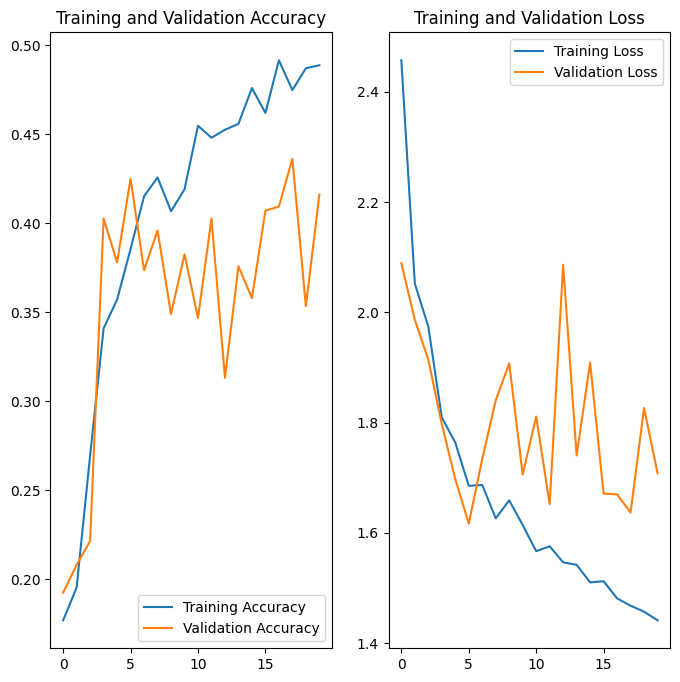

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Observations:
Accuracy:
The training and validation accuracy are steadily improving and closely aligned throughout the epochs.
No significant divergence is observed, indicating no overfitting.

Loss:
Both training and validation loss decrease over the epochs and remain fairly consistent.

Conclusion:
There is no clear evidence of severe overfitting or underfitting.
The model is well-trained, but monitoring the slight increase in validation loss at the later epochs is recommended.
Further improvements could include adding regularization techniques like dropout or early stopping to fine-tune performance.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
#to find the distribution of the classes in the training data set

# Specify the directory
directory = data_dir_train



# Count the number of images in each class
count = []
for path in pathlib.Path(directory).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path)
                          if os.path.isfile(os.path.join(path, name))]))

# Get the names of the classes (subdirectories)
sub_directory = [name for name in os.listdir(directory)
                 if os.path.isdir(os.path.join(directory, name))]

# Create a dataframe with image counts and class names
class_distribution = pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Image'])

# Display the dataframe
print(class_distribution)


                        Class  No. of Image
0           actinic keratosis           114
1     squamous cell carcinoma           181
2                       nevus           357
3  pigmented benign keratosis           462
4             vascular lesion           139
5        basal cell carcinoma           376
6              dermatofibroma            95
7                    melanoma           438
8        seborrheic keratosis            77


#### Findings:
#### - Which class has the least number of samples?
        Seborrheic keratosis (77 samples).


#### - Which classes dominate the data in terms proportionate number of samples?
        Pigmented benign keratosis (462 samples). Melanoma (438 samples).

#### Rectifying the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train / i)) # Changed this line
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BF06053C9D0>: 100%|██████████| 500/500 [00:28<00:00, 17.47 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BF07A321CC0>: 100%|██████████| 500/500 [00:22<00:00, 22.02 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BEFF83C27A0>: 100%|██████████| 500/500 [00:19<00:00, 25.77 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2816x2112 at 0x7BF07A3220E0>: 100%|██████████| 500/500 [01:32<00:00,  5.39 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x7BEFF810AC80>: 100%|██████████| 500/500 [01:22<00:00,  6.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BF07A321CC0>: 100%|██████████| 500/500 [00:18<00:00, 26.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BEFF83C3E50>: 100%|██████████| 500/500 [00:40<00:00, 12.22 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BEFF82A8460>: 100%|██████████| 500/500 [00:19<00:00, 25.00 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BF060617610>: 100%|██████████| 500/500 [00:21<00:00, 23.54 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030730.jpg_21301c6c-e7e4-4486-be7a-f2202a69e061.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028820.jpg_c0277f8d-fb97-4221-8726-8c2481f3498f.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_a42c6e39-0cfe-4d8d-90c5-276d2167fca9.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_8d3db85f-c4c2-4d9d-8632-a6f78d6488c

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
original_df=pd.DataFrame(columns = ['Path','Label'])
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [ ]:
new_df['Label'].value_counts()

,count
Label,
actinic keratosis,500
squamous cell carcinoma,500
nevus,500
pigmented benign keratosis,500
vascular lesion,500
basal cell carcinoma,500
dermatofibroma,500
melanoma,500
seborrheic keratosis,500


Added 500 images to all the classes to maintain some class balance.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [ ]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating model

In [ ]:
#Model 3
#creating the model including the normalization
# Define the Sequential model
model3 = Sequential([
    rescale,  # Rescaling Layer

    # First Convolutional Block
    layers.Conv2D(32, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Second Convolutional Block
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Third Convolutional Block
    layers.Conv2D(128, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),

    # Output Layer with Softmax
    layers.Dense(len(class_names), activation='softmax')
])


#### Compiling model

In [ ]:
#compiling the above code
model3.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Model Training

In [ ]:
epochs = 30 #using 30 epochs as provided in the problem statment
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 307ms/step - accuracy: 0.1420 - loss: 2.6634 - val_accuracy: 0.2131 - val_loss: 2.7474
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 250ms/step - accuracy: 0.2550 - loss: 2.0044 - val_accuracy: 0.3222 - val_loss: 2.5972
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 243ms/step - accuracy: 0.3868 - loss: 1.6557 - val_accuracy: 0.3215 - val_loss: 2.3207
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 86s 270ms/step - accuracy: 0.4311 - loss: 1.5154 - val_accuracy: 0.3036 - val_loss: 2.2693
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 244ms/step - accuracy: 0.4402 - loss: 1.4559 - val_accuracy: 0.3237 - val_loss: 1.7676
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 86s 266ms/step - accuracy: 0.4923 - loss: 1.3615 - val_accuracy: 0.3615 - val_loss: 1.5897
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 234ms/step - accuracy: 0.5008 - loss: 1.3246 - val_accuracy: 0.3645 - val_loss: 1.7051
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 254ms/step - accuracy: 0.5060 - loss: 1.2956 - val

#### Visualizing the model results

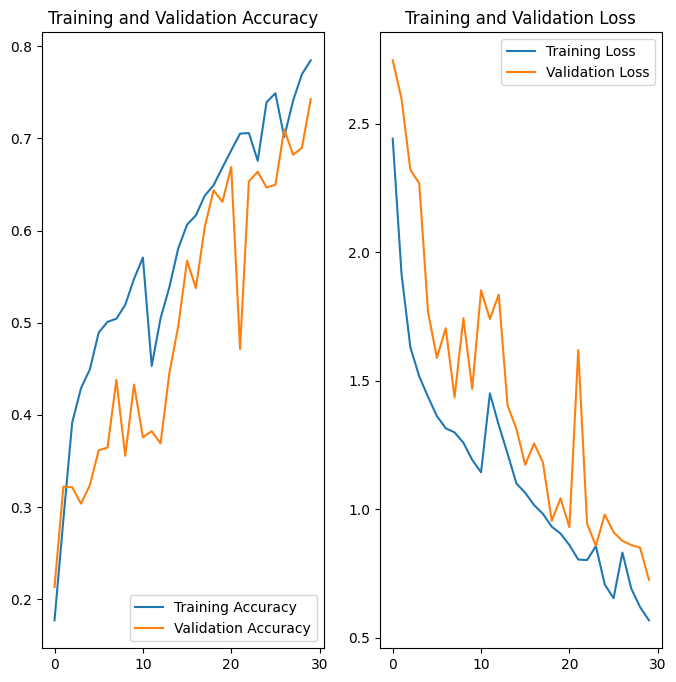

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Analyze the results of model3 (after data augmentation and class rebalancing)

# Observations from the training history plots:

# 1. Training Accuracy vs. Validation Accuracy:
#    - The training accuracy generally increases over epochs.
#    - The validation accuracy follows a similar trend, but with some fluctuations.  The gap between training and validation accuracy is less than previous models, suggesting reduced overfitting.

# 2. Training Loss vs. Validation Loss:
#    - The training loss decreases consistently.
#    - The validation loss also decreases initially but then appears to plateau or fluctuate slightly.  The gap is smaller than the previous models.


# Conclusion:

# - Overfitting/Underfitting:  
#Data augmentation and class rebalancing seem to have mitigated overfitting to some extent, as evidenced by the smaller gap between training and validation metrics.
#The model generalizes better to unseen data.  

# - Class Rebalance Help:
#The class rebalancing using Augmentor likely improved model performance.
#By addressing the class imbalance, the model is less likely to be biased towards the majority classes, and can better learn features from all classes.
#The initial class imbalance potentially caused the model to struggle with the minority classes.
#Adding more data through augmentation helped the model to better classify minority classes.
